In [1]:
from ast import literal_eval
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from rdkit.Chem import Descriptors, MolFromSmiles
from rdkit.Chem import QED
import matplotlib.pyplot as plt
import seaborn as sns

from utils import draw_venn

# Load dataset

In [2]:
DATA_DIR = "../data"
FIGURE_DIR = "../figures"

In [3]:
final_df = pd.read_csv(f"{DATA_DIR}/processed/combined_bioassay_data.tsv", sep="\t")
final_df.head(2)

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast,chemical_class,compound_superclass,compound_pathway,best_class
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_34,5.0,5.0,NaN,6.0,"['Amino cyclitols', 'Aminoglycosides']","['Aminosugars and aminoglycosides', 'Polyols']",['Carbohydrates'],acid-fast
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_34,NaN,NaN,6.0,NaN,['Chalcones'],['Flavonoids'],['Shikimates and Phenylpropanoids'],fungi


# Chemphys properties

In [4]:
cmp_df = final_df[["compound_smiles", "best_class"]]
cmp_df = cmp_df.drop_duplicates()

cmp_df.head(2)

,compound_smiles,best_class
0,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,acid-fast
1,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,fungi


In [5]:
data = []
for smile in tqdm(cmp_df["compound_smiles"].values):
    mol = MolFromSmiles(smile)

    p = QED.properties(mol)
    alerts = [i for i in p][-1]

    data.append(
        {
            "compound_smiles": smile,
            "mol_wt": Descriptors.MolWt(mol),
            "tpsa": Descriptors.TPSA(mol),
            "fraction_sp3": Descriptors.FractionCSP3(mol),
            "n_hba": Descriptors.NumHAcceptors(mol),
            "n_hbd": Descriptors.NumHDonors(mol),
            "logp": Descriptors.MolLogP(mol),
            "alerts": alerts,
        }
    )

tmp_df = pd.DataFrame(data)

100%|██████████| 74202/74202 [01:47<00:00, 689.14it/s] 


In [6]:
cmp_df = pd.merge(cmp_df, tmp_df, on="compound_smiles")

In [7]:
def check_ro5_violation(molecular_weight, n_hba, n_hbd, logp):
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return ro5_fulfilled

In [8]:
cmp_df["ro5_violation"] = cmp_df.apply(
    lambda x: check_ro5_violation(x["mol_wt"], x["n_hba"], x["n_hbd"], x["logp"]),
    axis=1,
)

In [9]:
cmp_df["ro5_violation"].value_counts()

True     55814
False    18388
Name: ro5_violation, dtype: int64

In [10]:
for class_name in cmp_df["best_class"].unique():
    print(f" \n Class: {class_name}")
    tmp = cmp_df[cmp_df["best_class"] == class_name]
    tmp = tmp.drop_duplicates(subset="compound_smiles")
    alert_counter = tmp["alerts"].value_counts().to_dict()
    combined_alerts = sum([v for k, v in alert_counter.items() if k != 0])
    print("Ro5 violations: ", tmp["ro5_violation"].value_counts().to_dict()[True])
    print("Structural alerts: ", len(alert_counter))
    print(
        "No alerts: ", alert_counter[0], f"({(alert_counter[0] / len(tmp)) * 100:.2f})"
    )
    print("Alerts: ", combined_alerts, f"({(combined_alerts / len(tmp)) * 100:.2f})")

 
 Class: acid-fast
Ro5 violations:  7739
Structural alerts:  7
No alerts:  2921 (31.55)
Alerts:  6337 (68.45)
 
 Class: fungi
Ro5 violations:  12108
Structural alerts:  8
No alerts:  4371 (29.78)
Alerts:  10309 (70.22)
 
 Class: gram-negative
Ro5 violations:  12065
Structural alerts:  12
No alerts:  4154 (26.79)
Alerts:  11353 (73.21)
 
 Class: gram-positive
Ro5 violations:  23902
Structural alerts:  9
No alerts:  10557 (30.37)
Alerts:  24200 (69.63)


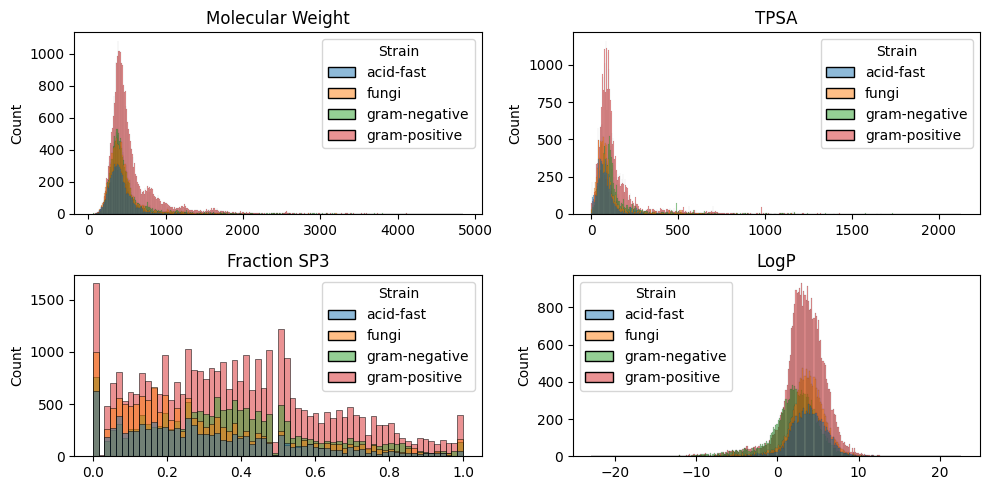

In [11]:
cmp_df.rename(columns={"best_class": "Strain"}, inplace=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5))

sns.histplot(data=cmp_df, x="mol_wt", hue="Strain", ax=ax1)
ax1.set_xlabel("")
ax1.set_title("Molecular Weight")

sns.histplot(data=cmp_df, x="tpsa", hue="Strain", ax=ax2)
ax2.set_xlabel("")
ax2.set_title("TPSA")

sns.histplot(data=cmp_df, x="fraction_sp3", hue="Strain", ax=ax3)
ax3.set_xlabel("")
ax3.set_title("Fraction SP3")

sns.histplot(data=cmp_df, x="logp", hue="Strain", ax=ax4)
ax4.set_xlabel("")
ax4.set_title("LogP")

plt.tight_layout()
plt.show()

# Getting information on chemical classes

In [12]:
chem_class_dict = defaultdict(lambda: defaultdict(set))
chem_superclass_dict = defaultdict(lambda: defaultdict(set))
chem_pathway_dict = defaultdict(lambda: defaultdict(set))

for idx, row in tqdm(final_df.iterrows(), total=len(final_df)):
    (
        inchikey,
        smiles,
        source,
        gram_pos,
        gram_neg,
        fungi,
        acid_fast,
        class_info,
        superclass_info,
        pathway_info,
        best_class,
    ) = row

    if pd.isna(class_info):
        class_info = "[]"

    if pd.isna(superclass_info):
        superclass_info = "[]"

    if pd.isna(pathway_info):
        pathway_info = "[]"

    class_info = literal_eval(class_info)
    superclass_info = literal_eval(superclass_info)
    pathway_info = literal_eval(pathway_info)

    for c in class_info:
        chem_class_dict[best_class][c].add(inchikey)

    for c in superclass_info:
        chem_superclass_dict[best_class][c].add(inchikey)

    for c in pathway_info:
        chem_pathway_dict[best_class][c].add(inchikey)

100%|██████████| 74202/74202 [00:01<00:00, 45163.91it/s]


# Generate clustermap

In [13]:
def get_cluster_map(data_dict, save_fig=False):
    t = []

    for class_name, class_dict in data_dict.items():
        k = defaultdict(int)
        for subclass, compounds in class_dict.items():
            k[subclass] = len(compounds)
        k["Strain"] = class_name.capitalize()
        t.append(k)

    class_df = pd.DataFrame(t).fillna(0)
    class_df.set_index("Strain", inplace=True)
    print(f"Shape of the dataframe: {class_df.shape}")

    # Normalize the data
    scaler = MinMaxScaler()
    for col in class_df.columns:
        class_df[col] = scaler.fit_transform(class_df[[col]])

    g = sns.clustermap(
        class_df,
        cmap="Reds",
        method="ward",
        figsize=(15, 10),
        standard_scale=1,
    )
    g.ax_heatmap.set_yticklabels(
        g.ax_heatmap.get_ymajorticklabels(), fontsize=12, va="center"
    )

    # plt.tight_layout()
    if save_fig:
        g.savefig(f"{FIGURE_DIR}/figure_4.png", dpi=400)

    plt.show()

Shape of the dataframe: (4, 411)


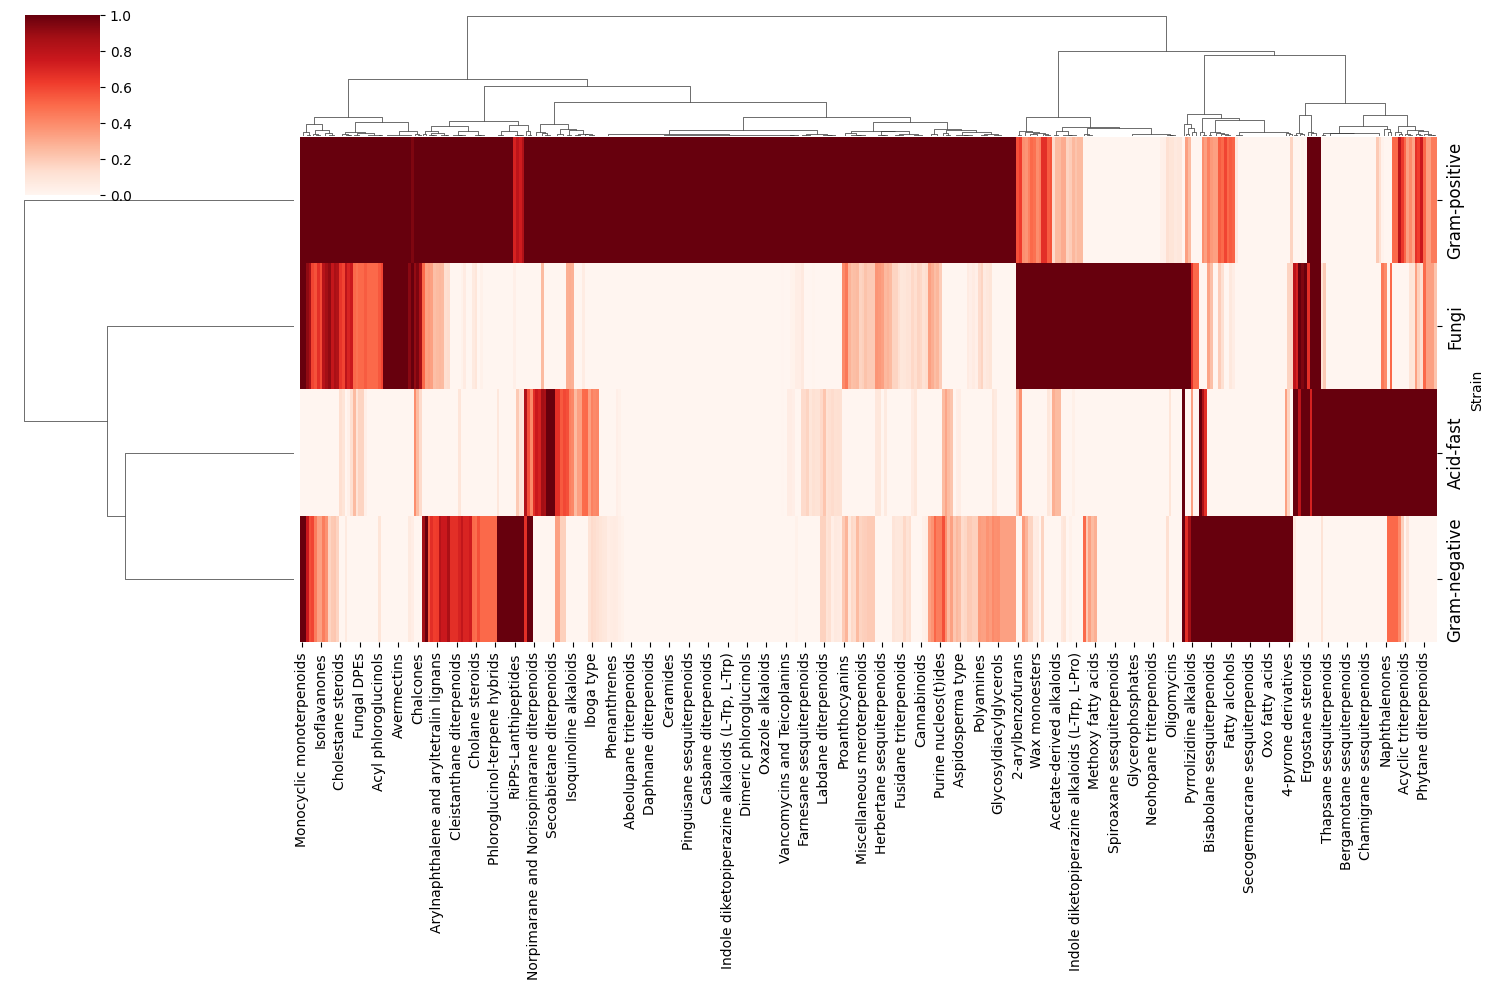

In [14]:
kk = get_cluster_map(chem_class_dict, save_fig=True)

Shape of the dataframe: (4, 67)


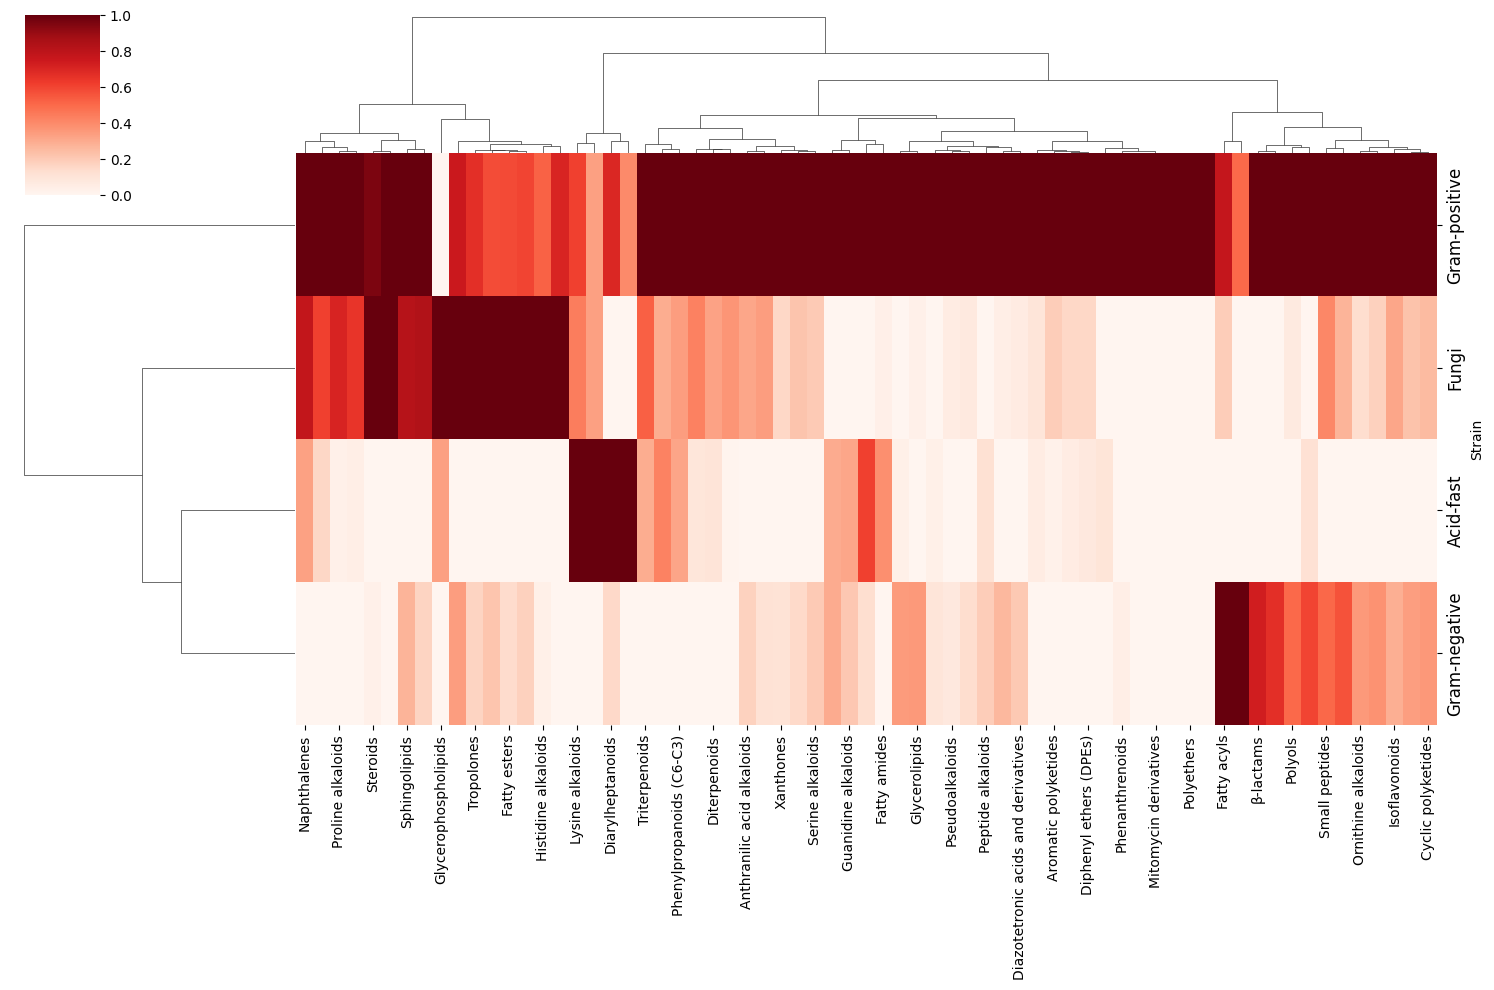

In [15]:
get_cluster_map(chem_superclass_dict)

Shape of the dataframe: (4, 7)


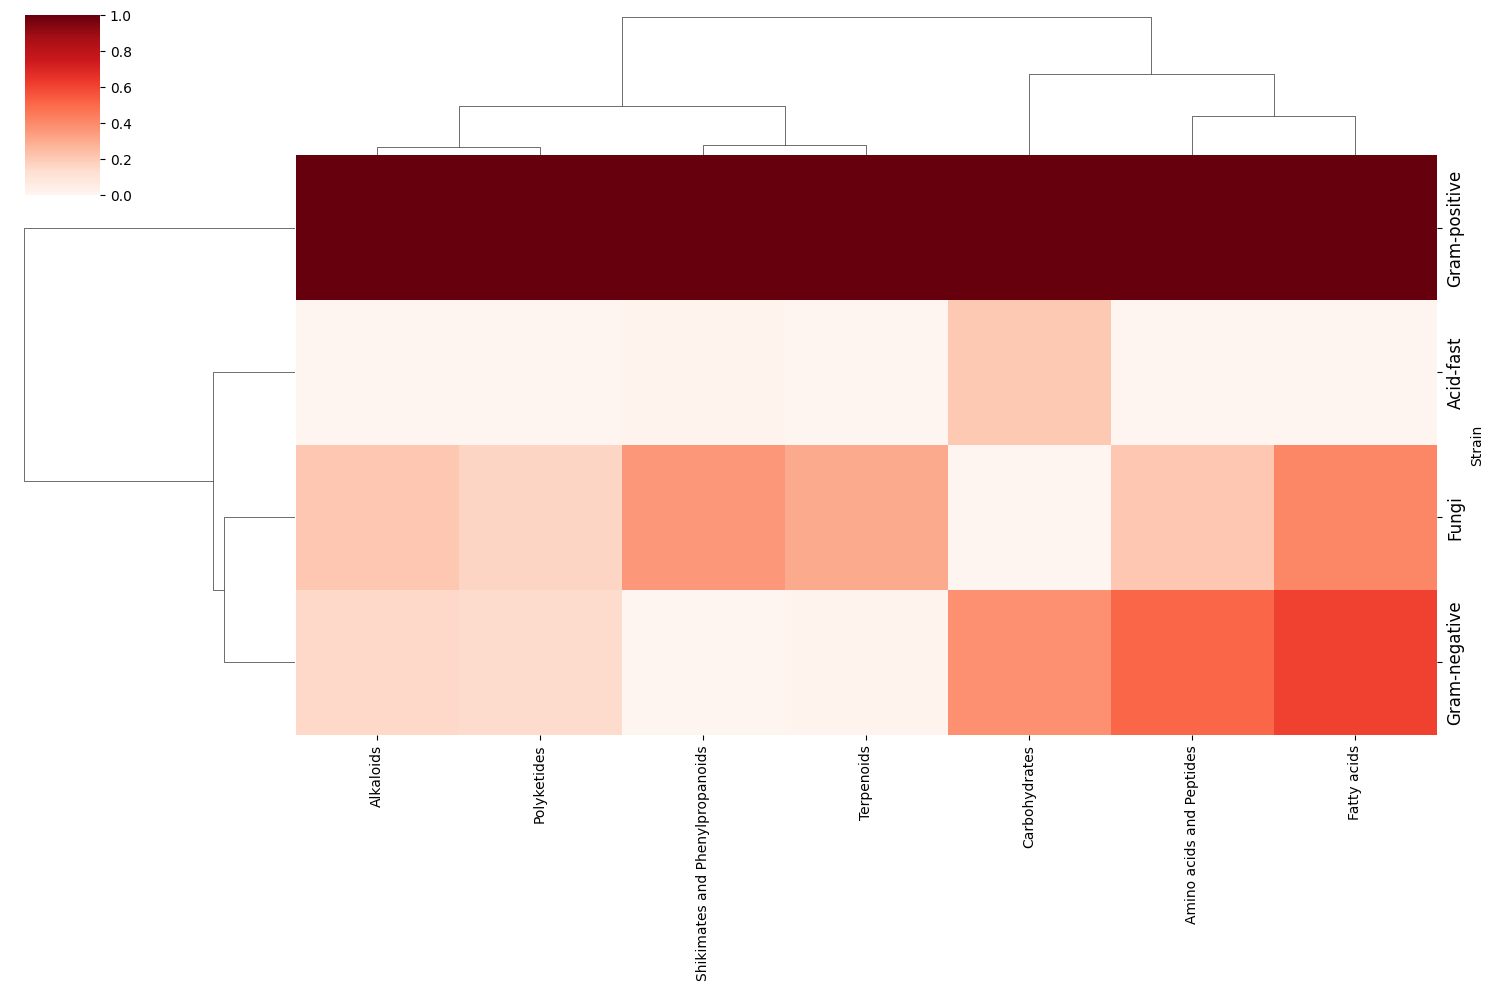

In [16]:
get_cluster_map(chem_pathway_dict)

# Deep dive into each category

In [17]:
def get_info_dict(data_dict):
    chem_class_counter_dict = {
        "gram-positive": {},
        "gram-negative": {},
        "fungi": {},
        "acid-fast": {},
    }

    for k, v in data_dict.items():
        for kk, vv in v.items():
            chem_class_counter_dict[k][kk] = len(vv)

    print(f"Gram positive: {len(chem_class_counter_dict['gram-positive'])}")
    print(f"Gram negative: {len(chem_class_counter_dict['gram-negative'])}")
    print(f"Fungi: {len(chem_class_counter_dict['fungi'])}")
    print(f"Acid fast: {len(chem_class_counter_dict['acid-fast'])}")

    gram_pos_classes = set(chem_class_counter_dict["gram-positive"].keys())
    gram_neg_classes = set(chem_class_counter_dict["gram-negative"].keys())
    fungi_classes = set(chem_class_counter_dict["fungi"].keys())
    acid_fast_classes = set(chem_class_counter_dict["acid-fast"].keys())

    draw_venn(
        {
            "gram-positive": gram_pos_classes,
            "gram-negative": gram_neg_classes,
            "fungi": fungi_classes,
            "acid-fast": acid_fast_classes,
        }
    )
    return chem_class_counter_dict

Gram positive: 340
Gram negative: 253
Fungi: 258
Acid fast: 207


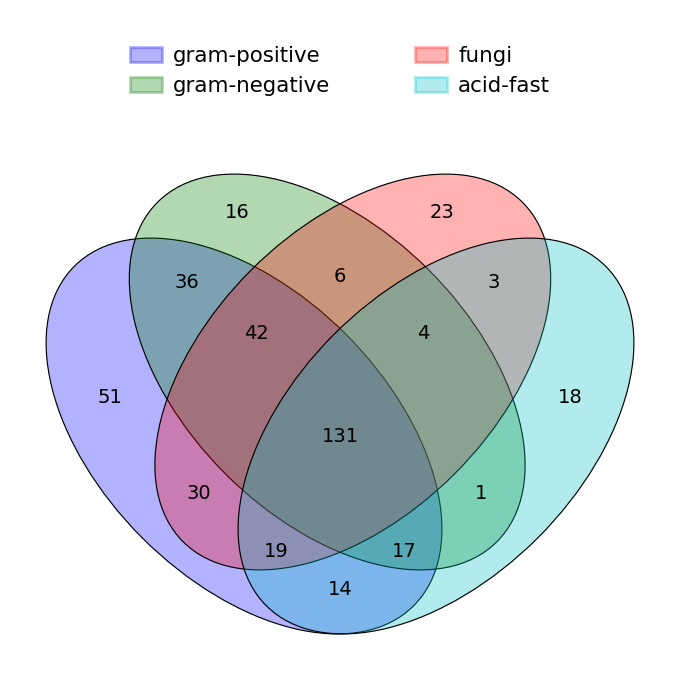

In [18]:
chem_class_counter_dict = get_info_dict(chem_class_dict)

In [19]:
gram_pos_classes = set(chem_class_counter_dict["gram-positive"].keys())
gram_neg_classes = set(chem_class_counter_dict["gram-negative"].keys())
fungi_classes = set(chem_class_counter_dict["fungi"].keys())
acid_fast_classes = set(chem_class_counter_dict["acid-fast"].keys())

In [20]:
gram_pos_only = gram_pos_classes.difference(
    gram_neg_classes.union(fungi_classes).union(acid_fast_classes)
)
gram_neg_only = gram_neg_classes.difference(
    gram_pos_classes.union(fungi_classes).union(acid_fast_classes)
)
fungi_only = fungi_classes.difference(
    gram_neg_classes.union(gram_pos_classes).union(acid_fast_classes)
)
acid_fast_only = acid_fast_classes.difference(
    gram_neg_classes.union(fungi_classes).union(gram_pos_classes)
)

In [21]:
len(gram_pos_only), len(gram_neg_only), len(fungi_only), len(acid_fast_only)

(51, 16, 23, 18)

In [22]:
def get_distiribution_plot(class_dict: dict, info_name: str):
    df_data = []

    for class_name in tqdm(class_dict):
        cmpd_couner = chem_class_counter_dict[info_name][class_name]
        df_data.append(
            {
                "class": class_name,
                "compound_count": cmpd_couner,
            }
        )

    df = pd.DataFrame(df_data)
    df.sort_values("compound_count", ascending=False, inplace=True)
    df["percentage"] = df["compound_count"] / df["compound_count"].sum() * 100
    df["percentage"] = df["percentage"].round(2)

    plt.figure(figsize=(12, 6))
    sns.barplot(x="class", y="percentage", data=df)
    plt.xticks(rotation=90)
    plt.show()

100%|██████████| 16/16 [00:00<00:00, 179435.47it/s]


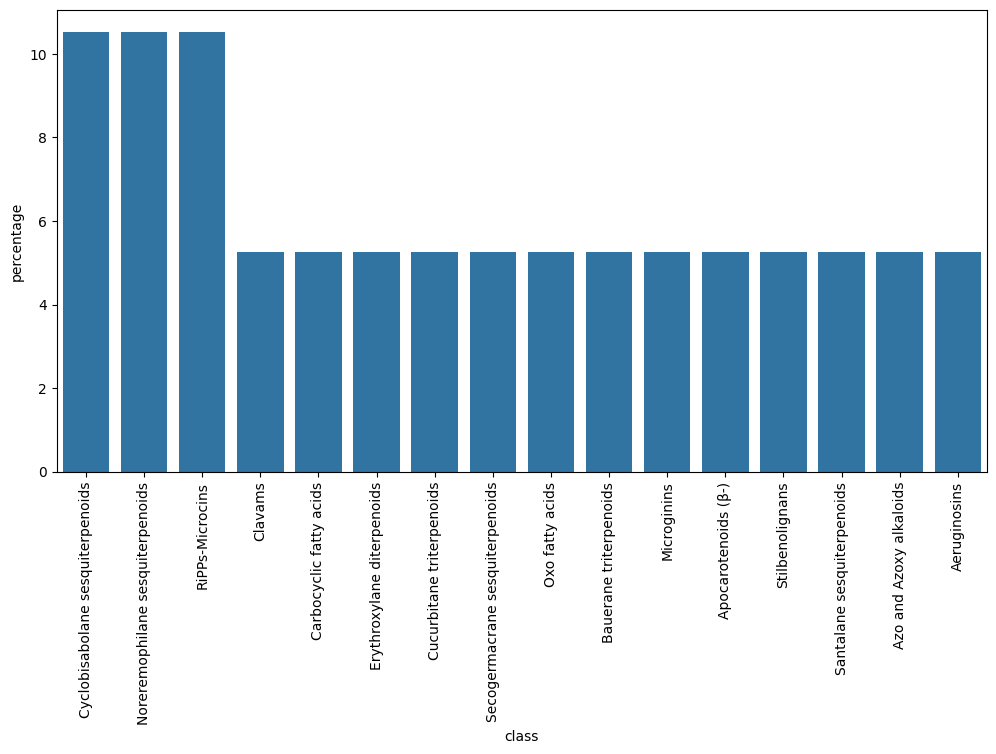

In [23]:
get_distiribution_plot(class_dict=gram_neg_only, info_name="gram-negative")

# Superclasses

Gram positive: 66
Gram negative: 58
Fungi: 59
Acid fast: 54


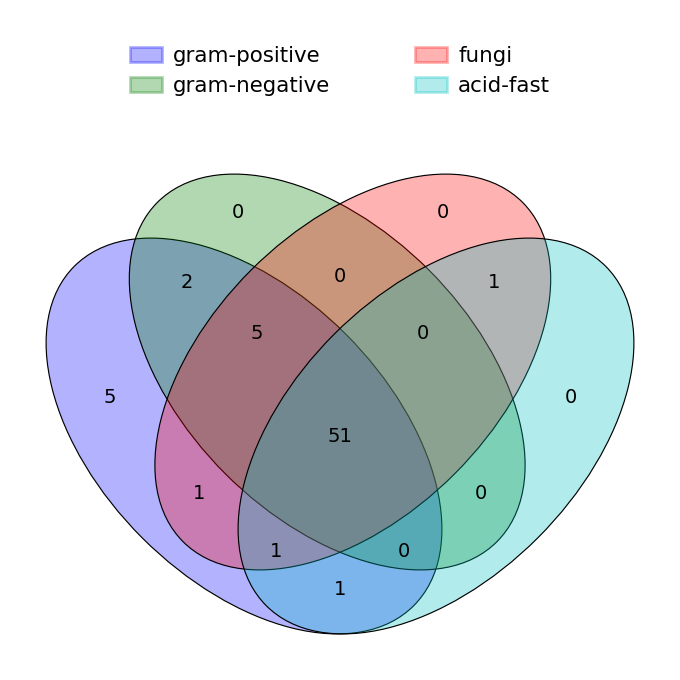

In [24]:
chem_superclass_counter_dict = get_info_dict(chem_superclass_dict)

# Pathways

Gram positive: 7
Gram negative: 7
Fungi: 7
Acid fast: 7


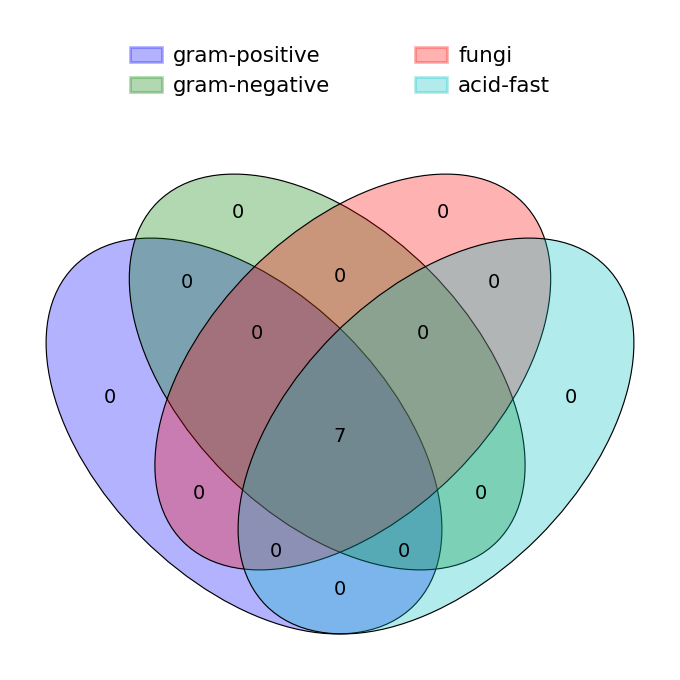

In [25]:
chem_pathway_counter_dict = get_info_dict(chem_pathway_dict)